In [2]:
import sys
sys.path.append('../..')

In [3]:
import h5py
import yaml
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

from utils import FluidDataset
from net import UNet4Diffusion
from diff_fluids.baseline.unet.net import UNet
from denoising_diffusion import DenoisingDiffusion

In [4]:
train_ds = FluidDataset(fileroot='../../data/', filename='ns_random_64x64_T50', is_test=False)
test_ds = FluidDataset(fileroot='../../data/', filename='ns_random_64x64_T50', is_test=True)

In [5]:
with open('./config.yaml') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    eps_model = UNet4Diffusion(**configs['eps_model'])
    eps_model.load_state_dict(torch.load('./checkpoint/fullsmoke64x64_N1000.pth'))
    diffuser = DenoisingDiffusion(
        eps_model=eps_model,
        **configs['diffuser']
    ).cuda(1)

In [8]:
with open('../baseline/unet/config.yaml', 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    unet = UNet(**configs['model']).cuda(1)
    unet.load_state_dict(torch.load('../baseline/unet/checkpoint/smoke64x64_T50_N1000.pth'))
    unet = unet.cuda(1)

### On Training set

In [32]:
x0, y0 = [], []
for i in range(4):
    sample = test_ds[2000+i*100]
    x0.append(sample['x'])
    y0.append(sample['y'])
x0 = torch.stack(x0)
y0 = torch.stack(y0)

In [33]:
x_pred_ddpm = diffuser.sample(torch.randn_like(x0).cuda(1), y0.cuda(1))

100%|██████████| 600/600 [00:20<00:00, 29.27it/s]


In [34]:
x_pred_unet = unet(y0.cuda(1))

In [35]:
x_pred_unet = x_pred_unet.detach().cpu()
x_pred_ddpm = x_pred_ddpm.detach().cpu()
u_pred_unet, vx_pred_unet, vy_pred_unet = torch.chunk(x_pred_unet, 3, dim=1)
u_pred_ddpm, vx_pred_ddpm, vy_pred_ddpm = torch.chunk(x_pred_ddpm, 3, dim=1)

In [36]:
u0, vx0, vy0 = torch.chunk(x0, 3, dim=1)

In [37]:
(u_pred_unet, vx_pred_unet, vy_pred_unet, 
    u_pred_ddpm, vx_pred_ddpm, vy_pred_ddpm,
    u0, vx0, vy0) = map(lambda x: x.squeeze(), (u_pred_unet, vx_pred_unet, vy_pred_unet,
                                               u_pred_ddpm, vx_pred_ddpm, vy_pred_ddpm,
                                               u0, vx0, vy0))

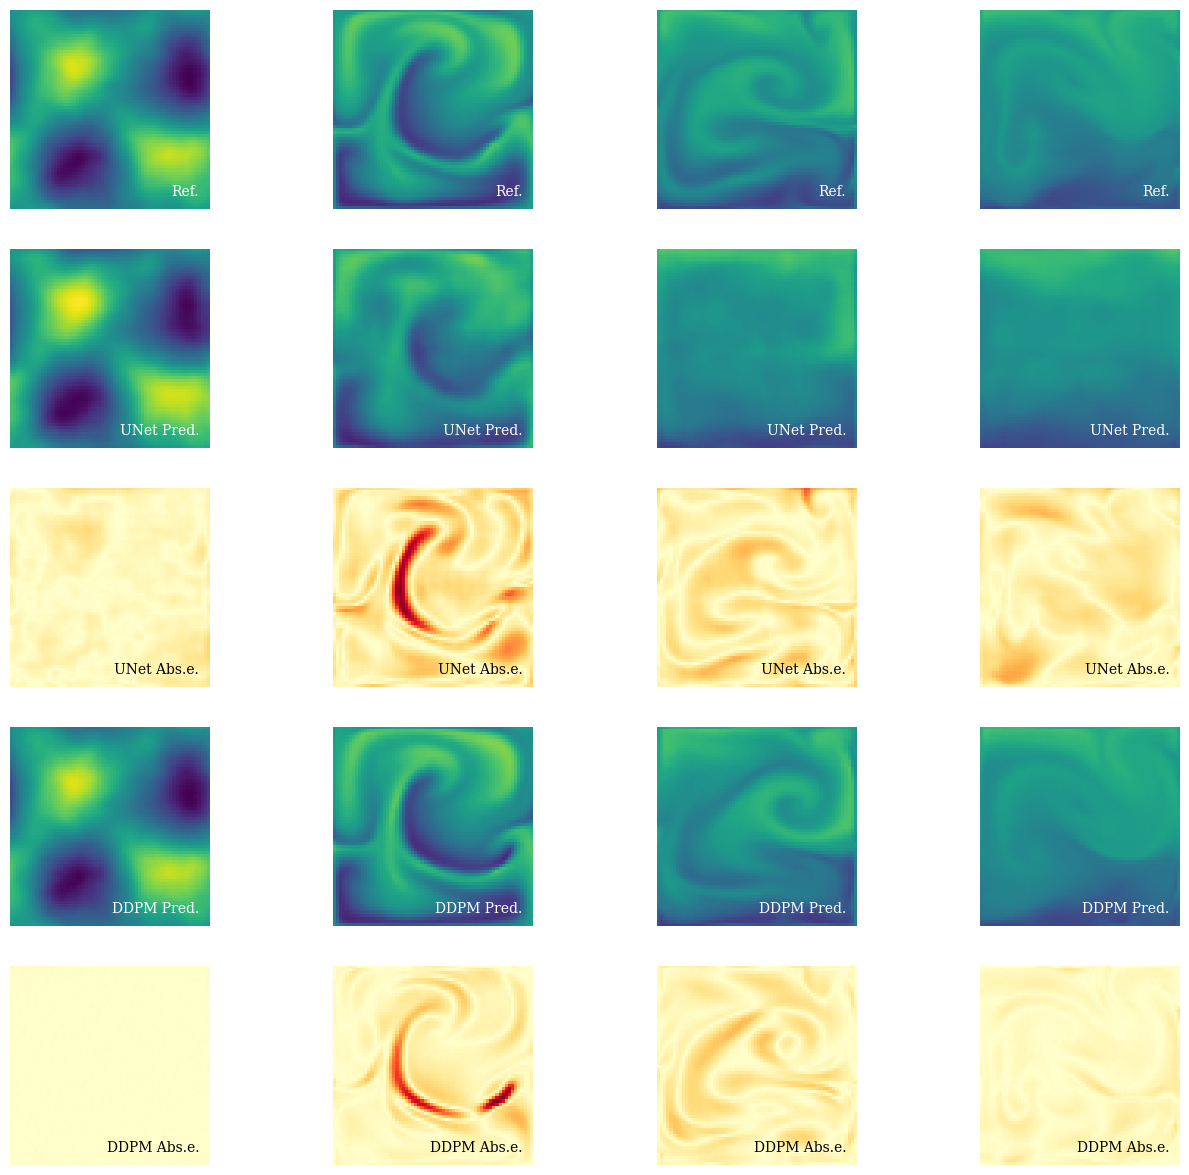

In [38]:
norm1 = colors.Normalize(vmin=min(u0.min(), u_pred_unet.min(), u_pred_ddpm.min()), vmax=max(u0.max(), u_pred_unet.max(), u_pred_ddpm.max()))
error1 = torch.abs(u_pred_unet - u0)
error2 = torch.abs(u_pred_ddpm - u0)
norm2 = colors.Normalize(vmin=error1.min(), vmax=error1.max())
norm3 = colors.Normalize(vmin=error2.min(), vmax=error2.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(5, 4, figsize=(16, 15))
for i in range(4):
    im1 = ax[0, i].imshow(u0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(u_pred_unet[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'UNet Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(torch.abs(error1[i]), norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'UNet Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
    ax[3, i].imshow(u_pred_ddpm[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[3, i].axis('off')
    ax[3, i].text(0.95, 0.05, 'DDPM Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[3, i].transAxes)
    im3 = ax[4, i].imshow(torch.abs(error2[i]), norm=norm3, cmap=cmap2, origin='lower')
    ax[4, i].axis('off')
    ax[4, i].text(0.95, 0.05, 'DDPM Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[4, i].transAxes)
# cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
# cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)

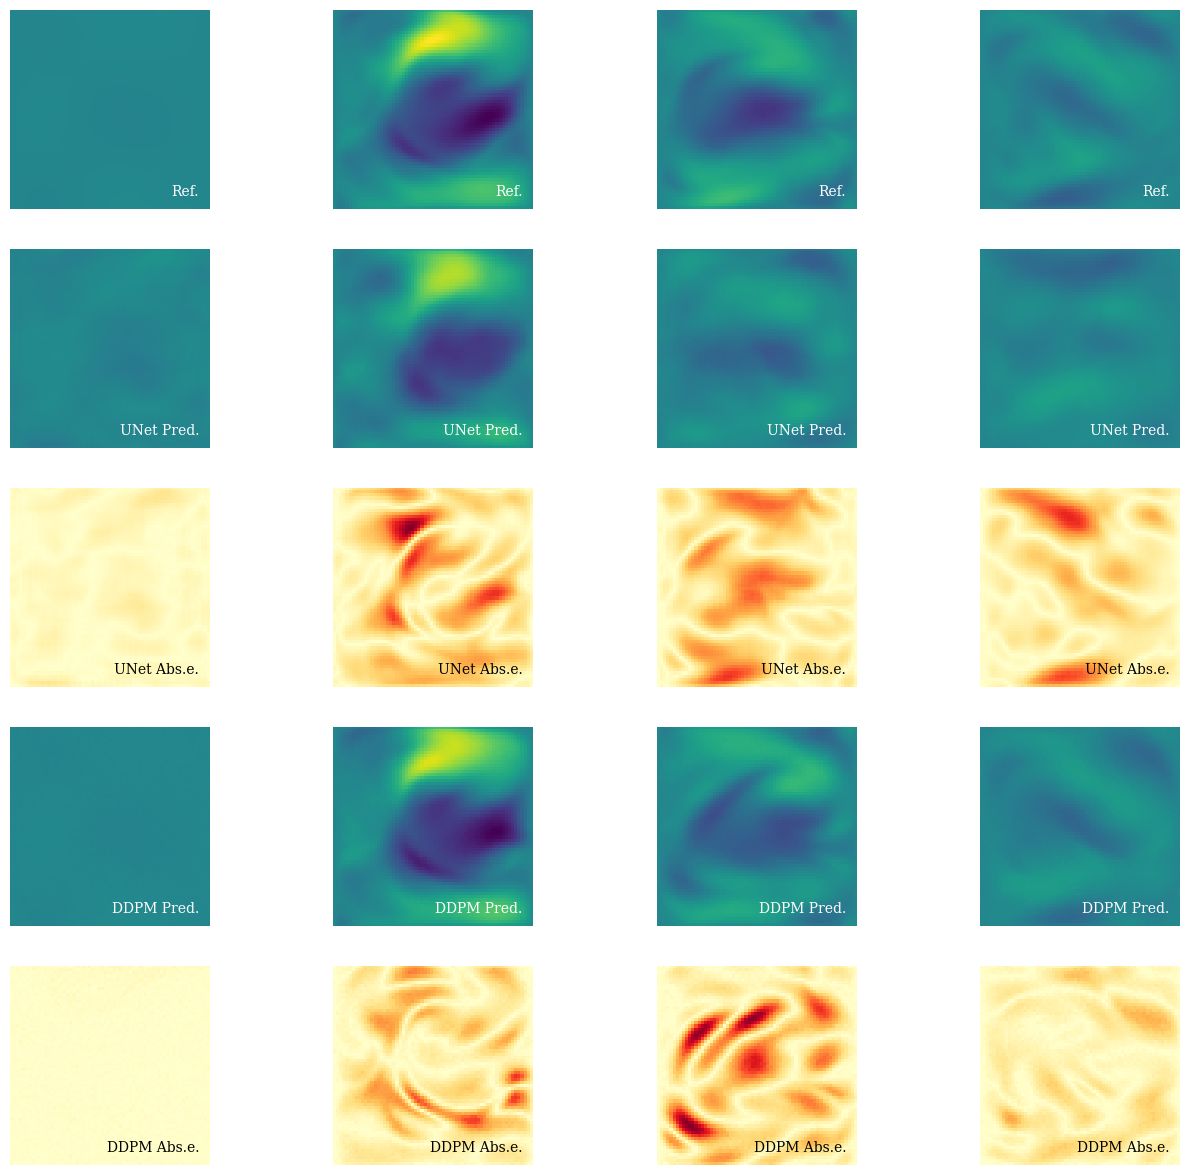

In [39]:
norm1 = colors.Normalize(vmin=min(vx0.min(), vx_pred_unet.min(), vx_pred_ddpm.min()), vmax=max(vx0.max(), vx_pred_unet.max(), vx_pred_ddpm.max()))
error1 = torch.abs(vx_pred_unet - vx0)
error2 = torch.abs(vx_pred_ddpm - vx0)
norm2 = colors.Normalize(vmin=error1.min(), vmax=error1.max())
norm3 = colors.Normalize(vmin=error2.min(), vmax=error2.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(5, 4, figsize=(16, 15))
for i in range(4):
    im1 = ax[0, i].imshow(vx0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(vx_pred_unet[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'UNet Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(torch.abs(error1[i]), norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'UNet Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
    ax[3, i].imshow(vx_pred_ddpm[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[3, i].axis('off')
    ax[3, i].text(0.95, 0.05, 'DDPM Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[3, i].transAxes)
    im3 = ax[4, i].imshow(torch.abs(error2[i]), norm=norm3, cmap=cmap2, origin='lower')
    ax[4, i].axis('off')
    ax[4, i].text(0.95, 0.05, 'DDPM Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[4, i].transAxes)

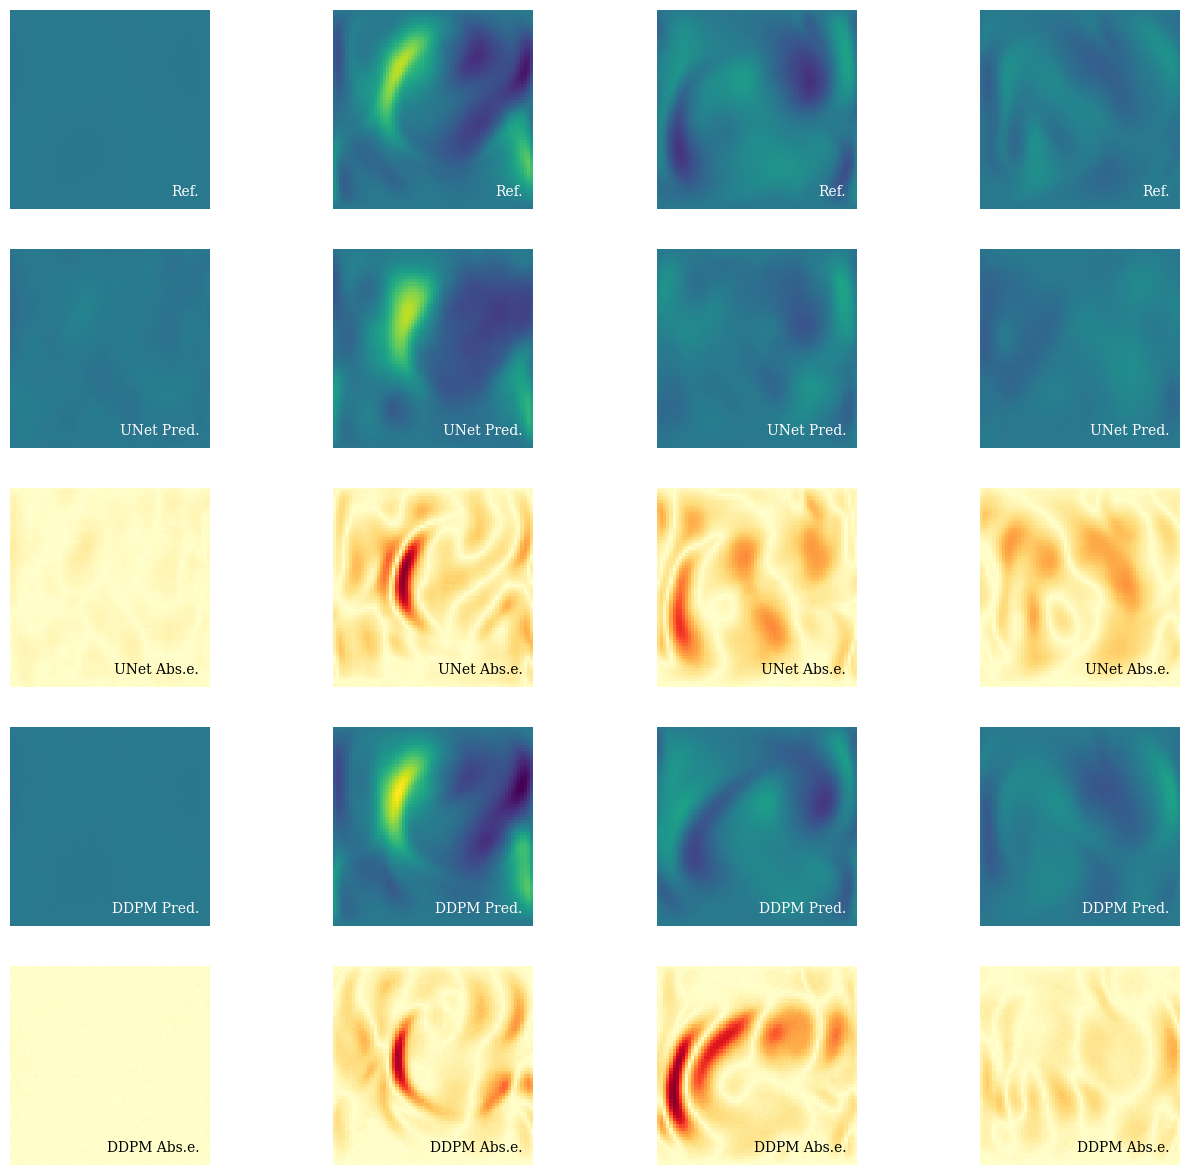

In [40]:
norm1 = colors.Normalize(vmin=min(vy0.min(), vy_pred_unet.min(), vy_pred_ddpm.min()), vmax=max(vy0.max(), vy_pred_unet.max(), vy_pred_ddpm.max()))
error1 = torch.abs(vy_pred_unet - vy0)
error2 = torch.abs(vy_pred_ddpm - vy0)
norm2 = colors.Normalize(vmin=error1.min(), vmax=error1.max())
norm3 = colors.Normalize(vmin=error2.min(), vmax=error2.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(5, 4, figsize=(16, 15))
for i in range(4):
    im1 = ax[0, i].imshow(vy0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(vy_pred_unet[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'UNet Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(torch.abs(error1[i]), norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'UNet Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
    ax[3, i].imshow(vy_pred_ddpm[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[3, i].axis('off')
    ax[3, i].text(0.95, 0.05, 'DDPM Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[3, i].transAxes)
    im3 = ax[4, i].imshow(torch.abs(error2[i]), norm=norm3, cmap=cmap2, origin='lower')
    ax[4, i].axis('off')
    ax[4, i].text(0.95, 0.05, 'DDPM Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[4, i].transAxes)